In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading dataset
df = pd.read_csv('./weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


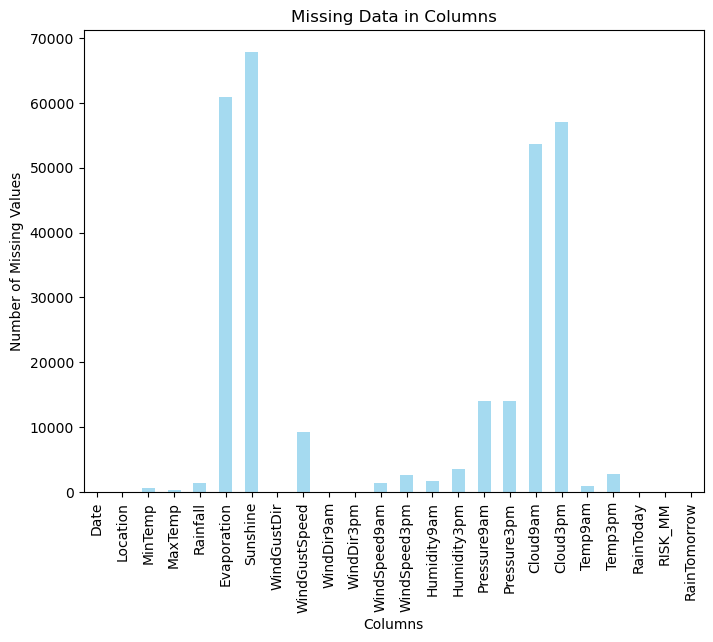

In [6]:
# Find missing data
missing_data = df.isnull().sum()

# Plotting
plt.figure(figsize=(8, 6))
missing_data.plot(kind='bar', color='skyblue', alpha=0.75)
plt.title('Missing Data in Columns')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=90)
plt.show()

In [7]:
# Handling categorical variables 
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: pd.factorize(x)[0])

# Apply MICE imputation to handle missing data
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert categorical columns back to original dtype
df_imputed[categorical_cols] = df_imputed[categorical_cols].apply(lambda x: x.round().astype('int'))
df_imputed[categorical_cols] = df_imputed[categorical_cols].apply(lambda x: pd.Categorical.from_codes(x, df[categorical_cols].apply(lambda y: y.astype('category').cat.categories)))


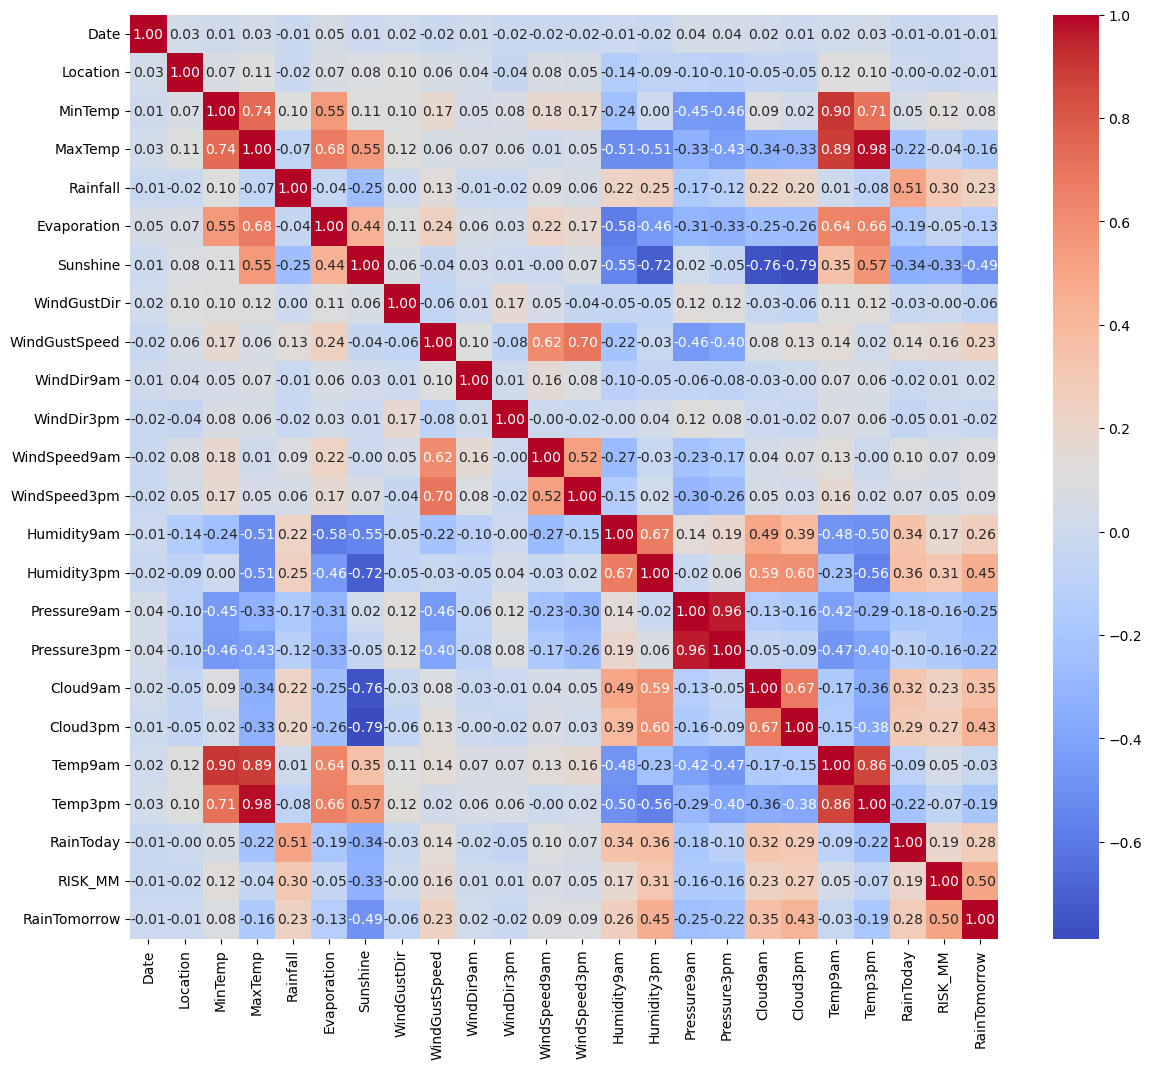

In [8]:
# Calculating the correlation matrix
corr_matrix = df_imputed.corr()

# Display the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Get the correlation of each feature with the target variable 'RainTomorrow'
correlation_with_target = corr_matrix['RainTomorrow'].sort_values(ascending=False)


# droping columns with correlation less than a certain threshold with RainTomorrow
threshold = 0.01
columns_to_keep = correlation_with_target[correlation_with_target.abs() > threshold].index

df_imputed.drop(['Date','Location'],axis=1,inplace=True)

In [17]:

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply label encoding to each column
for column in df_imputed.columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Applying MinMaxScaler to normalize the values
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)


In [18]:
X = df_normalized.drop('RainTomorrow', axis=1)
Y = df_normalized['RainTomorrow']

In [19]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
# Initialize the Random Forest model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)


# Predict probabilities
y_train_pred_prob = model.predict_proba(X_train)
y_test_pred_prob = model.predict_proba(X_test)

# Calculate log loss
train_loss = log_loss(y_train, y_train_pred_prob)
test_loss = log_loss(y_test, y_test_pred_prob)

print(f"Training Loss: {train_loss}")
print(f"Testing Loss: {test_loss}")

Training Loss: 0.0032131092296115164
Testing Loss: 0.008850677006147518


In [21]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate F1 score
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

print(f"Training F1 Score: {train_f1}")
print(f"Testing F1 Score: {test_f1}")


Training Accuracy: 1.0
Testing Accuracy: 1.0
Training F1 Score: 1.0
Testing F1 Score: 1.0


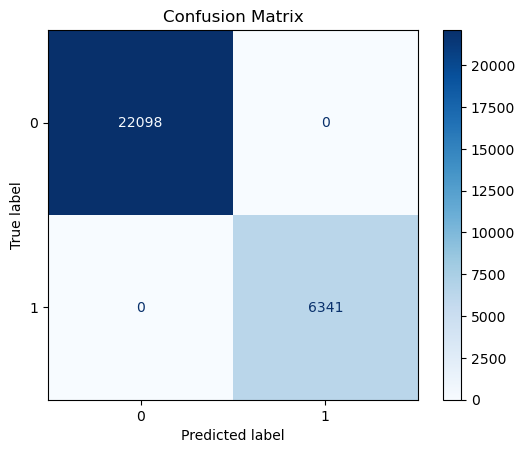

In [22]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()